In [1]:
import numpy as np
np.set_printoptions(precision=2)
from time import time

from mrobotics.piecewise.polyline import waypoints
import matplotlib.pyplot as plt

In [2]:
mywaypoints = waypoints(np.array([
    [-3.0,4.0],
    [0.0,0.0],
    [+4.0, 3.0],
    [6.0, 2.0]
]))

test_arclengths = np.linspace(-2.0, 15.0, 100) # a very dense sample

## A basic test

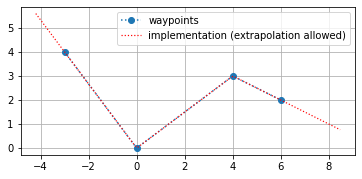

In [3]:
pts_test = np.array([mywaypoints.get_pos(test_arclen,clip=False) for test_arclen in test_arclengths])
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation allowed)')
ax.legend()
plt.show()

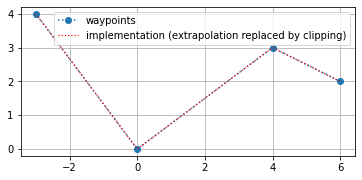

In [4]:
pts_test = np.array([mywaypoints.get_pos(test_arclen,clip=True) for test_arclen in test_arclengths])
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

In [5]:
print("Inspect the breakpoint")
print(mywaypoints.idx2arclen)

Inspect the breakpoint
[ 0.    5.   10.   12.24]


In [6]:
for test_param in test_arclengths[::10]:
    print("unit tangent at", f"{test_param:3.2f}".rjust(7), mywaypoints.get_utang(test_param))

unit tangent at   -2.00 [ 0.6 -0.8]
unit tangent at   -0.28 [ 0.6 -0.8]
unit tangent at    1.43 [ 0.6 -0.8]
unit tangent at    3.15 [ 0.6 -0.8]
unit tangent at    4.87 [ 0.6 -0.8]
unit tangent at    6.59 [0.8 0.6]
unit tangent at    8.30 [0.8 0.6]
unit tangent at   10.02 [ 0.89 -0.45]
unit tangent at   11.74 [ 0.89 -0.45]
unit tangent at   13.45 [ 0.89 -0.45]


In [7]:
for test_arclen in test_arclengths:
    utang_computed = mywaypoints.get_utang(test_arclen)
    utang_computed_norm = np.linalg.norm(utang_computed)
    assert np.allclose(utang_computed_norm, 1.0), f"got {utang_computed_norm:.2f}"

## Add waypoints to extend the polyline path

In [8]:
mywaypoints.add(np.array([5,1]))

In [9]:
print("Inspect the breakpoint again (after adding the new point)")
mywaypoints.idx2arclen

Inspect the breakpoint again (after adding the new point)


array([ 0.  ,  5.  , 10.  , 12.24, 13.65])

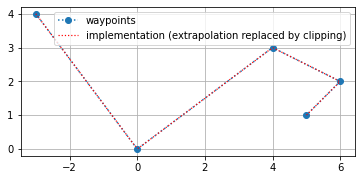

In [10]:
pts_test = np.array([mywaypoints.get_pos(test_arclen,clip=True) for test_arclen in test_arclengths])
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

## Validate the query point projection
Find
$$
s^*(\vec q) 
\triangleq 
\text{ argmin}_{s \in \mathbb{R}} 
|[\vec q - \vec p(s) ] \cdot \hat n(s)|
= 
 \text{ argmin}_{s \in \mathbb{R}} 
([\vec q - \vec p(s) ] \cdot \hat n(s))^2
$$

where 

* $\vec q$ is the query point
* $\vec p(s)$ is the point of our parametric curve evaluated at $s$ (with extrapolation)
* $\hat n(s)$ is the unit normal of the parametric curve evaluated at $s$ (with extrapolation)


Instead of searching for the true globally.
We have a stateful computation:

* avoid abrupt changes in the arclength (to some extent, cf. the Padan et al. (2017) paper for an illustration).

* We might also prefer the local minimizer that is closer to the "previous path progress estimate" instead of the global minimum.

In [11]:
# the following query point has three local minima! 
test_query_pt = np.array([4.0,2.0])
for init_guess in (6.0, 10.0 , 13.0):
    t0 = time()
    res = mywaypoints.project(test_query_pt ,arclength_init_guess=init_guess)
    t1 = time()
    final_pos, final_u_tang_vec = mywaypoints.get_pos_utang(res, clip=False)
    final_u_normal_vec = np.array([final_u_tang_vec[1], - final_u_tang_vec[0]])
    dist = np.abs(np.dot(test_query_pt-final_pos, final_u_normal_vec) )
    print(
        f"init guess: {init_guess:.2f}", f"final iterate: {res:.2f}",  
        f"normal distance: {dist:.2}", f"took {(t1-t0)*1e3:.2} msec", sep=', ') 

init guess: 6.00, final iterate: 9.40, normal distance: 0.8, took 0.2 msec
init guess: 10.00, final iterate: 10.45, normal distance: 0.89, took 0.18 msec
init guess: 13.00, final iterate: 13.65, normal distance: 1.4, took 0.093 msec


In [12]:
# the following query point has two local minima! 
test_query_pt = np.array([0.0,1.0])
for init_guess in (2.0, 6.0):
    t0 = time()
    res = mywaypoints.project(test_query_pt ,arclength_init_guess=init_guess)
    t1 = time()
    final_pos, final_u_tang_vec = mywaypoints.get_pos_utang(res, clip=False)
    final_u_normal_vec = np.array([final_u_tang_vec[1], - final_u_tang_vec[0]])
    dist = np.abs(np.dot(test_query_pt-final_pos, final_u_normal_vec) )
    print(
        f"init guess: {init_guess:.2f}", f"final iterate: {res:.2f}",  
        f"normal distance: {dist:.2}", f"took {(t1-t0)*1e3:.2} msec", sep=', ') 

init guess: 2.00, final iterate: 4.20, normal distance: 0.6, took 0.12 msec
init guess: 6.00, final iterate: 5.60, normal distance: 0.8, took 0.081 msec


In [13]:
# some perturbation to the query point
print(mywaypoints.project(np.array([-0.5,1.0]),arclength_init_guess=6.0)) # hang on to the 2nd segment
print(mywaypoints.project(np.array([-0.8,1.0]),arclength_init_guess=6.0)) # abrupt change!

5.2
3.7199999999999998
